# Beispiel: Frequenzlauf für den bimorphen Kragbalken

## Geometrie
besteht aus 2 Teilen (Schichten) aus dem gleichen Material, 3 Elektroden. Alle Ebenen haben Normalvektor in pos. Koordinatenrichtung, das wird bei Differenzen/Schnittmengen berücksichtigt

In [22]:
import netgen.gui
%gui tk

from netgen.geom2d import SplineGeometry

from ngsolve import *


## there may be conflicting versions for netgen-gui and matplotlib
## to import matplotlib, but without tkinter backend, uncomment two lines
# import matplotlib as mpl
# mpl.use('Agg')
import matplotlib.pyplot as plt

import numpy as np

In [23]:
#### Geometry
scale = 1e3  # --> computation in mm
h = 0.002*scale
b = 0.01*scale
l = 0.1*scale

geometry = SplineGeometry()

#       4--------------------------5
# (fix) |        (free_el2)        | (tip)   matnr 1
#       2--------------------------3
# (fix) |       (free_el0)         | (tip)   matnr 2
#       0--------------------------1
#            (free_el1)
geometry.AppendPoint(x=0, y=-h)
geometry.AppendPoint(x=l, y=-h)
geometry.AppendPoint(x=0, y=0)
geometry.AppendPoint(x=l, y=0)
geometry.AppendPoint(x=0, y=h)
geometry.AppendPoint(x=l, y=h)

geometry.Append( ["line", 0, 1], bc="free_el1", leftdomain=2, rightdomain=0)
geometry.Append( ["line", 2, 3], bc="free_el0", leftdomain=1, rightdomain=2)
geometry.Append( ["line", 4, 5], bc="free_el2", leftdomain=0, rightdomain=1)
geometry.Append( ["line", 0, 2], bc="fix", leftdomain=0, rightdomain=2)
geometry.Append( ["line", 2, 4], bc="fix", leftdomain=0, rightdomain=1)
geometry.Append( ["line", 1, 3], bc="tip", leftdomain=2, rightdomain=0)
geometry.Append( ["line", 3, 5], bc="tip", leftdomain=1, rightdomain=0)



netgenmesh = geometry.GenerateMesh(maxh=0.002*scale)
mesh = Mesh(netgenmesh)
mesh.Refine()
Draw(mesh)


 Generate Mesh from spline geometry
 Mesh bisection
 Bisection done


In [31]:
use_plane_stress = True

In [32]:
def strainvec(u):
    g = grad(u)
    return CoefficientFunction((g[0], g[3], g[1]+g[2]))


c11 = 121.
c22 = 122.
c12 = 75.9
c13 = 75.4
c23 = 75.4
c33 = 111
c55 = 21.1
eps11 = 916
eps22 = 916
eps33 = 830
e15 = 12.3
e24 = 12.3
e31 = -5.4
e32 = -5.4
e33 = 15.8

epsilon0 = 8.853e-12

if use_plane_stress:
    # Material constants C^E, epsilon, e of PZT, plane stress
    CEtensor = CoefficientFunction( (c11-(c12*c12)/c22, c13-c23*c12/c22, 0,    c13-c23*c12/c22,c33-c23*c23/c22,0,   0, 0, c55), dims = (3,3))

    epstensor = CoefficientFunction( (eps11*epsilon0, 0, 0,  (eps33+e32*e32/c22)*epsilon0), dims=(2,2))

    etensor = CoefficientFunction ((0,0,e15,    e31-c12*e32/c22 ,e33-c23*e32/c22,0), dims=(2,3))
else:
    CEtensor = CoefficientFunction( (c11, c13, 0,    c13,c33,0,   0, 0, c55), dims = (3,3))
    epstensor = CoefficientFunction( (eps11*epsilon0, 0, 0,  eps33*epsilon0), dims=(2,2))
    etensor = CoefficientFunction ((0,0,e15,    e31 ,e33,0), dims=(2,3))


etensor = (1./scale)*etensor
CEtensor = 1e9/scale/scale*CEtensor

density = 7750/scale**4

## FE

In [33]:
## the finite element solution space

## for the displacements - vector-valued H1 elements, dirichlet-zero condition on "fix" bd
V_u = VectorH1(mesh, order=3, dirichlet="fix")

## for the electric potential - H1 elements, dirichlet-zero condition on electrodes
V_phi = H1(mesh, order=3, dirichlet=".*el.")

## together 
V = V_u * V_phi
q = GridFunction(V)

u = q.components[0]
phi = q.components[1]

strain = strainvec(u)
elfield = -grad(phi)

stress = CEtensor*strain - etensor.trans*elfield
diel = etensor*strain + epstensor*elfield

Draw(u, mesh, "u")
Draw(phi, mesh, "phi")
Draw(BoundaryFromVolumeCF(elfield), mesh, "E")
Draw(BoundaryFromVolumeCF(strain), mesh, "strain")
Draw(BoundaryFromVolumeCF(diel), mesh, "D")
Draw(BoundaryFromVolumeCF(stress), mesh, "stress")

Setzen von phi0

In [34]:
## potential Phi = Phi_0 + Phi_tilde (homogenzation of boundary conditions)
## set finite element function U_0 boundary values
phi_0 = GridFunction(V_phi)

phi_bdvalues = mesh.BoundaryCF({"free_el1": 75, "free_el2": 75, "free_el0": 0}, default=0)
# phi_bdvalues = mesh.BoundaryCF({"free_el1": 0, "free_el2": 0, "free_el0": 0}, default=0)
phi_0.Set(phi_bdvalues, definedon=mesh.Boundaries(".*el."))

t = 1e-2

Wir stellen jetzt Steifigkeits- und Massenmatrix auf. Wieder verwenden wir Großbuchstaben für die symbolischen Größen, damit sie sich von den FE-Funktionen mit FE-Vektor unterscheiden.



In [35]:
## definition of the bilinear form 
## int sigma : deps - D dE dx
U, PHITILDE = V.TrialFunction()
DELTAU, DELTAPHI = V.TestFunction()

STRAIN = strainvec(U)
DELTASTRAIN = strainvec(DELTAU)

a = BilinearForm(V)
a += SymbolicBFI( InnerProduct(CEtensor*STRAIN + etensor.trans*(grad(PHITILDE)+grad(phi_0)), DELTASTRAIN) )
a += SymbolicBFI( InnerProduct(etensor*STRAIN - epstensor*(grad(PHITILDE)+grad(phi_0)), grad(DELTAPHI)) )
# a += SymbolicBFI(t*DELTAU[2], definedon=mesh.Boundaries("tip"))

## definition mass matrix
## int rho u deltau dx

m = BilinearForm(V)
m += SymbolicBFI(density*InnerProduct(U, DELTAU))




In [36]:
a.AssembleLinearization(q.vec)
m.AssembleLinearization(q.vec)

rhs = q.vec.CreateVector()
a.Apply(q.vec, rhs)
rhs.data *= -1

## dummy matrix for storing - omega^2 M + K
helpmatrix = a.mat.CreateMatrix()

Für verschiedene Frequenzen omega wird nur gelöst, und für jedes omega die Durchbiegung ausgewertet.

In [37]:
omegalist = []
displist = []

filename = "frequenzlauf_"
if use_plane_stress: filename += "planestress_"
else: filename += "planestrain_"
filename += ".txt"
outputfile = open(filename, "w")
for omega in range(0,10000,100):
    helpmatrix.AsVector().data = - omega**2*m.mat.AsVector() + a.mat.AsVector()
    inv = helpmatrix.Inverse(V.FreeDofs(), inverse="pardiso")

    q.vec.data = inv * rhs
    
    disp_avg = 1/(2*h)*Integrate(u[1], mesh, definedon=mesh.Boundaries("tip"))
    
    omegalist += [omega]
    displist += [abs(disp_avg)]
    print(f"{omegalist[-1]}\t{displist[-1]}", file=outputfile)
    outputfile.flush()
outputfile.close()

    

/var/folders/7k/qv8q_x7j7zb1j_js1j824fm00000gq/T/ipykernel_1174/603854593.py:9: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


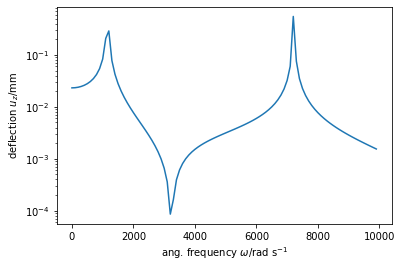

In [39]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.semilogy()
ax.set_xlabel(r"ang. frequency $\omega$/rad s$^{-1}$")
ax.set_ylabel(r"deflection $u_z$/mm")

ax.plot(omegalist, displist)
fig.savefig('bimbeam_freq_2d.png')
fig.show()
